In [ ]:
!pip install -q nltk

import pandas as pd
import numpy as np
import nltk
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("/flipkart_com-ecommerce_sample.csv", encoding='utf-8')
df = df[['product_name', 'product_category_tree']]
df.dropna(inplace=True)
df['category'] = df['product_category_tree'].apply(lambda x: eval(x)[0].split('>>')[0].strip())
df = df[['product_name', 'category']]
df.columns = ['title', 'category']
df.head()


,title,category
0,Alisha Solid Women's Cycling Shorts,Clothing
1,FabHomeDecor Fabric Double Sofa Bed,Furniture
2,AW Bellies,Footwear
3,Alisha Solid Women's Cycling Shorts,Clothing
4,Sicons All Purpose Arnica Dog Shampoo,Pet Supplies


In [ ]:
# Keep only top 15 most frequent categories
top_categories = df['category'].value_counts().nlargest(15).index
df = df[df['category'].isin(top_categories)].reset_index(drop=True)
print("Remaining categories:", df['category'].nunique())
df.head()


Remaining categories: 15


,title,category
0,Alisha Solid Women's Cycling Shorts,Clothing
1,AW Bellies,Footwear
2,Alisha Solid Women's Cycling Shorts,Clothing
3,Alisha Solid Women's Cycling Shorts,Clothing
4,"dilli bazaaar Bellies, Corporate Casuals, Casuals",Footwear


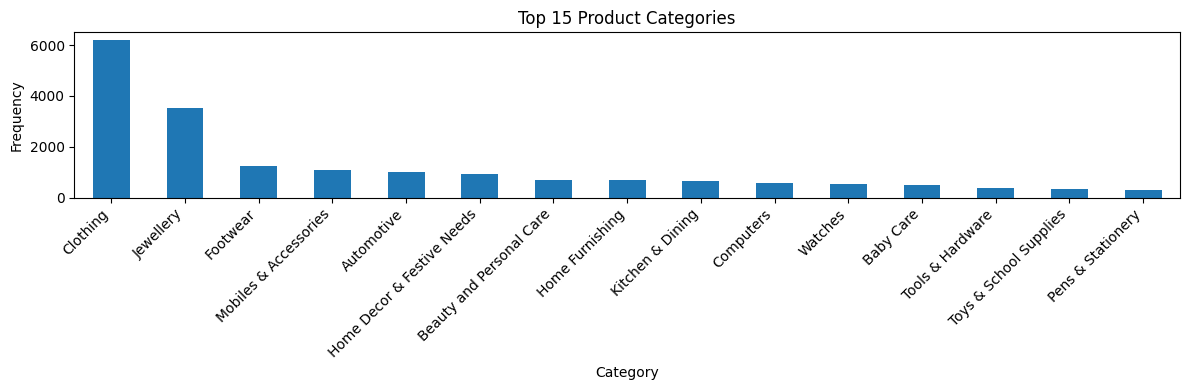

In [ ]:
df['category'].value_counts().plot(kind='bar', figsize=(12, 4))
plt.title("Top 15 Product Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_title'] = df['title'].apply(clean_text)
df.head()


,title,category,clean_title
0,Alisha Solid Women's Cycling Shorts,Clothing,alisha solid womens cycling shorts
1,AW Bellies,Footwear,aw bellies
2,Alisha Solid Women's Cycling Shorts,Clothing,alisha solid womens cycling shorts
3,Alisha Solid Women's Cycling Shorts,Clothing,alisha solid womens cycling shorts
4,"dilli bazaaar Bellies, Corporate Casuals, Casuals",Footwear,dilli bazaaar bellies corporate casuals casuals


In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_title'], df['label'], test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
labels_present = np.unique(y_test)
target_names = le.inverse_transform(labels_present)
print(classification_report(y_test, y_pred, labels=labels_present, target_names=target_names))



Accuracy: 0.9657387580299786
                            precision    recall  f1-score   support

                Automotive       0.98      0.96      0.97       216
                 Baby Care       0.96      0.74      0.84        97
  Beauty and Personal Care       0.96      0.91      0.94       140
                  Clothing       0.97      1.00      0.98      1258
                 Computers       0.97      0.94      0.95       109
                  Footwear       1.00      0.99      0.99       218
Home Decor & Festive Needs       0.92      0.98      0.95       182
           Home Furnishing       0.93      0.99      0.96       146
                 Jewellery       0.99      1.00      0.99       702
          Kitchen & Dining       0.92      0.89      0.90       117
     Mobiles & Accessories       0.98      0.98      0.98       210
         Pens & Stationery       0.94      0.66      0.77        70
          Tools & Hardware       1.00      0.93      0.97        89
    Toys & School 

In [ ]:
df_preds = pd.DataFrame({
    'title': X_test,
    'true_category': le.inverse_transform(y_test),
    'predicted_category': le.inverse_transform(y_pred)
})
df_preds.to_csv("sample_predictions.csv", index=False)
df_preds.head()


,title,true_category,predicted_category
3422,printland cmw ceramic mug,Kitchen & Dining,Kitchen & Dining
16737,portia hat,Baby Care,Clothing
7014,wise guys sofia first cartoon art plastic penc...,Toys & School Supplies,Toys & School Supplies
9877,kushies baby baby girls shrug,Baby Care,Baby Care
6415,junk multicolour flower brass necklace,Jewellery,Jewellery


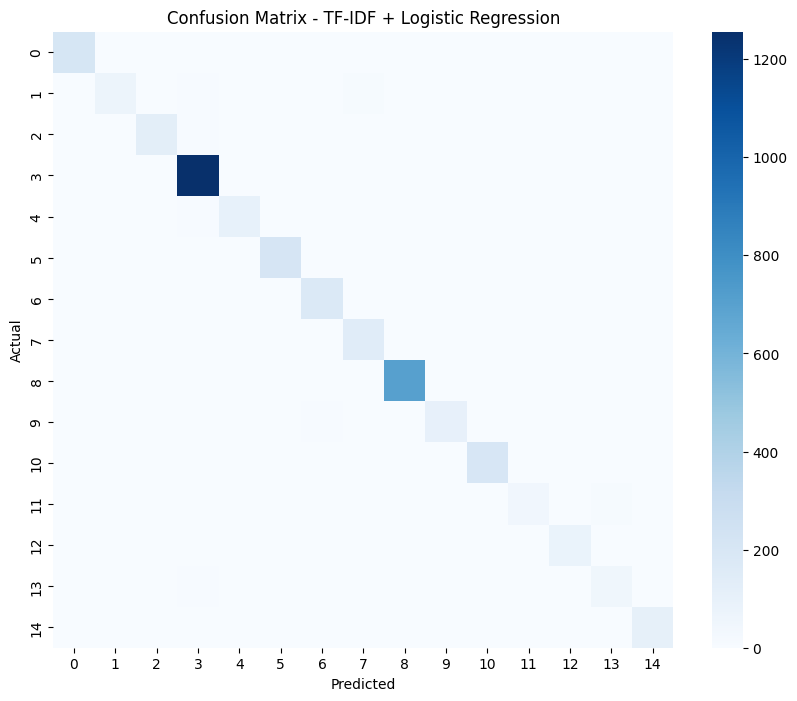

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap='Blues')
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_title'])
sequences = tokenizer.texts_to_sequences(df['clean_title'])
padded = pad_sequences(sequences, padding='post', maxlen=20)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(padded, df['label'], test_size=0.2, random_state=42)

num_classes = len(le.classes_)


In [ ]:
model = models.Sequential([
    layers.Embedding(input_dim=5000, output_dim=64, input_length=20),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_pad, y_train_pad, validation_data=(X_test_pad, y_test_pad), epochs=5, batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.3600 - loss: 2.0672 - val_accuracy: 0.6512 - val_loss: 0.9449
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7441 - loss: 0.7188 - val_accuracy: 0.9221 - val_loss: 0.3042
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9355 - loss: 0.2323 - val_accuracy: 0.9427 - val_loss: 0.2057
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9680 - loss: 0.1178 - val_accuracy: 0.9497 - val_loss: 0.1967
Epoch 5/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9770 - loss: 0.0873 - val_accuracy: 0.9518 - val_loss: 0.1884


In [ ]:
y_pred_dl = np.argmax(model.predict(X_test_pad), axis=1)

print("Accuracy:", accuracy_score(y_test_pad, y_pred_dl))
labels_present = np.unique(y_test)
target_names = le.inverse_transform(labels_present)
print(classification_report(y_test, y_pred, labels=labels_present, target_names=target_names))


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.9518201284796574
                            precision    recall  f1-score   support

                Automotive       0.98      0.96      0.97       216
                 Baby Care       0.96      0.74      0.84        97
  Beauty and Personal Care       0.96      0.91      0.94       140
                  Clothing       0.97      1.00      0.98      1258
                 Computers       0.97      0.94      0.95       109
                  Footwear       1.00      0.99      0.99       218
Home Decor & Festive Needs       0.92      0.98      0.95       182
           Home Furnishing       0.93      0.99      0.96       146
                 Jewellery       0.99      1.00      0.99       702
          Kitchen & Dining       0.92      0.89      0.90       117
     Mobiles & Accessories       0.98      0.98      0.98       210
         Pens & Stationery       0.94      0.66      0.77        70
          Tools & Hardware       1.00      0.

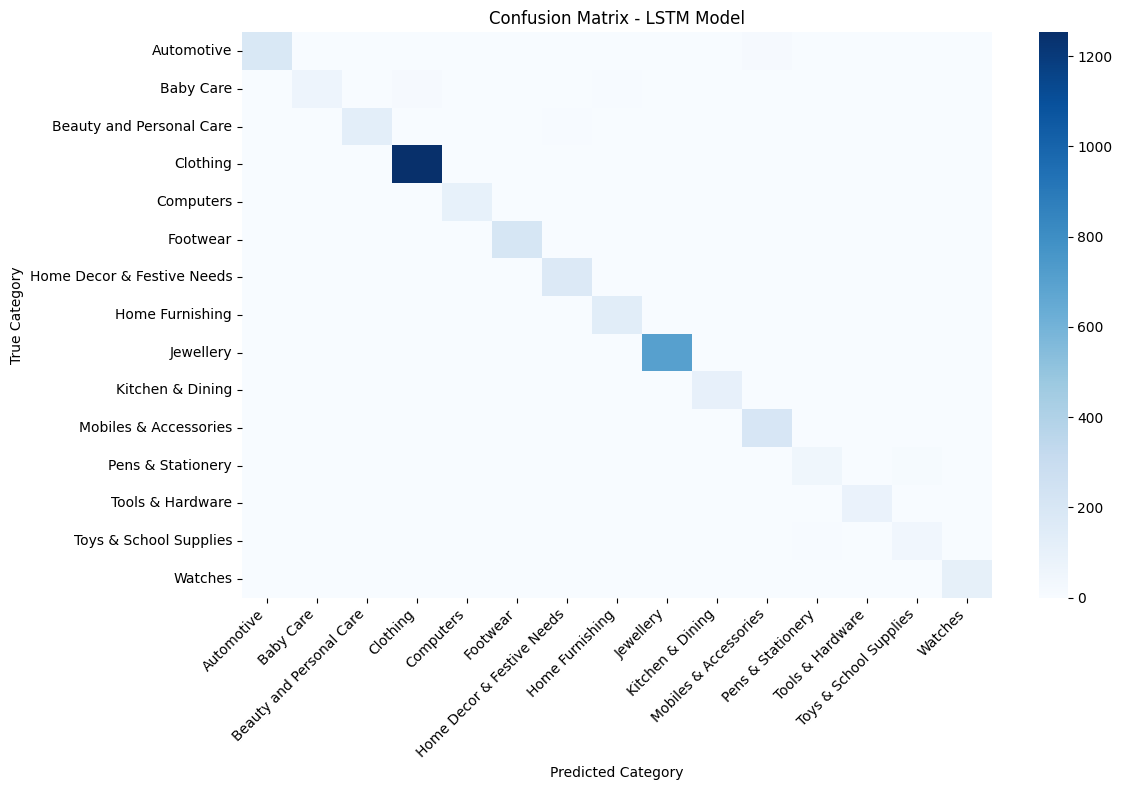

In [38]:
cm = confusion_matrix(y_test_pad, y_pred_dl)
labels = le.inverse_transform(np.unique(y_test_pad))

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
def predict_title(title):
    text = clean_text(title)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=20, padding='post')
    pred = np.argmax(model.predict(pad))
    return le.inverse_transform([pred])[0]

examples = [
    "Wireless Bluetooth Headphones",
    "Cotton Saree with Blouse Piece",
    "LED Strip Light for Home Decoration",
    "Non-stick Frying Pan",
]

for ex in examples:
    print(f"{ex} → {predict_title(ex)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Wireless Bluetooth Headphones → Mobiles & Accessories
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Cotton Saree with Blouse Piece → Baby Care
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
LED Strip Light for Home Decoration → Home Decor & Festive Needs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Non-stick Frying Pan → Kitchen & Dining


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Weighted Precision: {precision:.3f}")
print(f"Weighted Recall: {recall:.3f}")
print(f"Weighted F1 Score: {f1:.3f}")

Weighted Precision: 0.966
Weighted Recall: 0.966
Weighted F1 Score: 0.965
